In [90]:
import pandas as pd
import matplotlib.pyplot as pl
from keras.preprocessing.text import one_hot
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)




In [91]:
df_main=pd.read_json('train-v2.0.json')

In [92]:
df_main.head()

,version,data
0,v2.0,"{'title': 'Beyoncé', 'paragraphs': [{'qas': [{..."
1,v2.0,"{'title': 'Frédéric_Chopin', 'paragraphs': [{'..."
2,v2.0,{'title': 'Sino-Tibetan_relations_during_the_M...
3,v2.0,"{'title': 'IPod', 'paragraphs': [{'qas': [{'qu..."
4,v2.0,{'title': 'The_Legend_of_Zelda:_Twilight_Princ...


In [93]:
df_main.shape

(442, 2)

In [94]:
temp=df_main['data'][0]

In [95]:
par=temp['paragraphs']

In [96]:
ques=par[0]['qas']
ques[0]

{'question': 'When did Beyonce start becoming popular?',
 'id': '56be85543aeaaa14008c9063',
 'answers': [{'text': 'in the late 1990s', 'answer_start': 269}],
 'is_impossible': False}

In [97]:
title=[]
questions=[]
answers=[]
answer_start=[]
is_answerable=[]

In [98]:
for sample in df_main['data']:
    pars=sample['paragraphs']
    for par in pars:
        ques=par['qas']
        for i in ques:
            questions.append(i['question'])
            if i['answers']:
                answers.append(i['answers'][0]['text'])
                answer_start.append(i['answers'][0]['answer_start'])
            else:
                answers.append('Null')
                answer_start.append('Null')
            is_answerable.append(i['is_impossible'])

In [99]:
len(questions),len(answers),len(answer_start),len(is_answerable)

(130319, 130319, 130319, 130319)

In [100]:
df=pd.DataFrame({'Question':questions,
                 'Answers':answers,
                 'Answer_start':answer_start,
                 'Is_answerable':is_answerable
                })

In [101]:
df.head(10)

,Question,Answers,Answer_start,Is_answerable
0,When did Beyonce start becoming popular?,in the late 1990s,269,False
1,What areas did Beyonce compete in when she was...,singing and dancing,207,False
2,When did Beyonce leave Destiny's Child and bec...,2003,526,False
3,In what city and state did Beyonce grow up?,"Houston, Texas",166,False
4,In which decade did Beyonce become famous?,late 1990s,276,False
5,In what R&B group was she the lead singer?,Destiny's Child,320,False
6,What album made her a worldwide known artist?,Dangerously in Love,505,False
7,Who managed the Destiny's Child group?,Mathew Knowles,360,False
8,When did Beyoncé rise to fame?,late 1990s,276,False
9,What role did Beyoncé have in Destiny's Child?,lead singer,290,False


In [102]:
dev_data=pd.read_json('dev-v2.0.json')

In [103]:
questions=[]
answers=[]
answer_start=[]
is_answerable=[]
for sample in dev_data['data']:
    pars=sample['paragraphs']
    for par in pars:
        ques=par['qas']
        for i in ques:
            questions.append(i['question'])
            if i['answers']:
                answers.append(i['answers'][0]['text'])
                answer_start.append(i['answers'][0]['answer_start'])
            else:
                answers.append('Null')
                answer_start.append('Null')
            is_answerable.append(i['is_impossible'])
dev_df=pd.DataFrame({'Question':questions,
                 'Answers':answers,
                 'Answer_start':answer_start,
                 'Is_answerable':is_answerable
                })

In [104]:
dev_df

,Question,Answers,Answer_start,Is_answerable
0,In what country is Normandy located?,France,159,False
1,When were the Normans in Normandy?,10th and 11th centuries,94,False
2,From which countries did the Norse originate?,"Denmark, Iceland and Norway",256,False
3,Who was the Norse leader?,Rollo,308,False
4,What century did the Normans first gain their ...,10th century,671,False
...,...,...,...,...
11868,What is the seldom used force unit equal to on...,sthène,665,False
11869,What does not have a metric counterpart?,Null,Null,True
11870,What is the force exerted by standard gravity ...,Null,Null,True
11871,What force leads to a commonly used unit of mass?,Null,Null,True


<IPython.core.display.Javascript object>

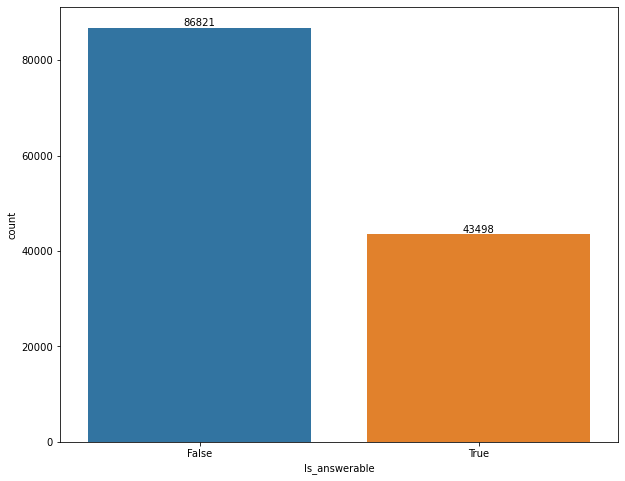

In [105]:
pl.figure(figsize=(10,8))

ax=sns.countplot(df['Is_answerable'])
rects=ax.patches

for rect in rects:
    height=rect.get_height()
    ax.text(x=rect.get_x()+rect.get_width()/2,y=height+5,s=height,ha='center',va='bottom')
pl.show()

<IPython.core.display.Javascript object>

-0.4 0.8
0.6 0.8


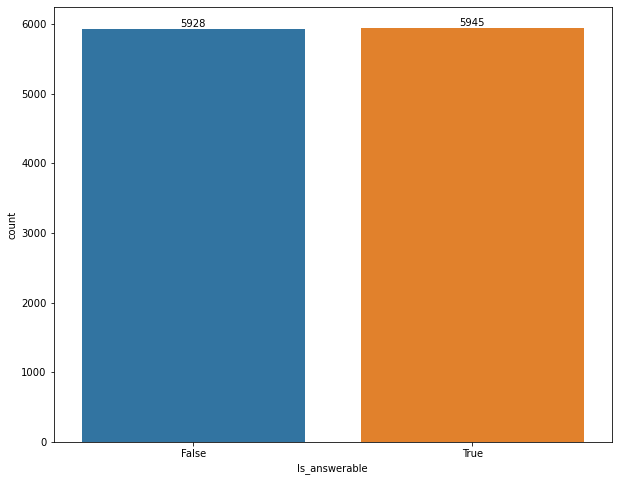

In [106]:
pl.figure(figsize=(10,8))

ax=sns.countplot(dev_df['Is_answerable'])
rects=ax.patches
for rect in rects:
    height=rect.get_height()
    print(rect.get_x(),rect.get_width())
    ax.text(x=rect.get_x()+rect.get_width()/2,y=height+1,s=height,ha='center',va='bottom')
pl.show()

In [107]:
len(df),df['Answer_start'].nunique()

(130319, 1604)

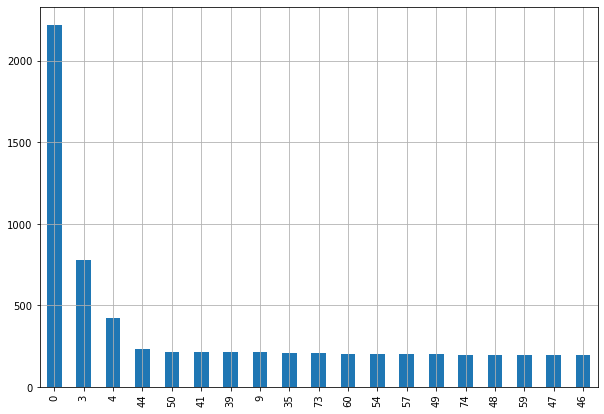

In [108]:
df['Answer_start'].value_counts()[1:20].plot(kind='bar',figsize=(10,7))
pl.grid()
pl.show()

In [109]:
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

In [110]:
df['len_que']=df['Question'].apply(lambda x: len(x))
df['len_ans']=df['Answers'].apply(lambda x: len(x))

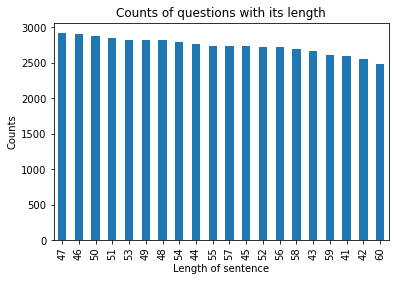

In [111]:
df['len_que'].value_counts()[:20].plot.bar()
pl.title('Counts of questions with its length')
pl.xlabel('Length of sentence')
pl.ylabel('Counts')
pl.show()

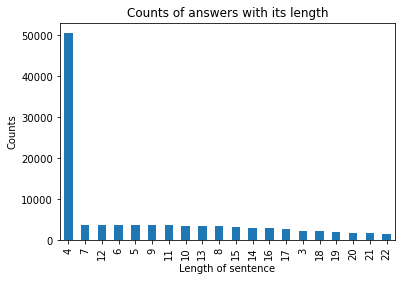

In [112]:
df['len_ans'].value_counts()[:20].plot.bar()
pl.title('Counts of answers with its length')
pl.xlabel('Length of sentence')
pl.ylabel('Counts')
pl.show()

In [113]:
df.describe()

,len_que,len_ans
count,130319.000000,130319.000000
mean,58.507739,14.758884
std,73.757111,19.193666
min,1.000000,1.000000
25%,44.000000,4.000000
50%,55.000000,7.000000
75%,69.000000,17.000000
max,25651.000000,239.000000


In [114]:
df.drop(107709,axis=0,inplace=True)

In [115]:
df.reset_index(drop=True,inplace=True)

In [116]:
df.head()

,Question,Answers,Answer_start,Is_answerable,len_que,len_ans
0,When did Beyonce start becoming popular?,in the late 1990s,269,False,40,17
1,What areas did Beyonce compete in when she was...,singing and dancing,207,False,58,19
2,When did Beyonce leave Destiny's Child and bec...,2003,526,False,64,4
3,In what city and state did Beyonce grow up?,"Houston, Texas",166,False,45,14
4,In which decade did Beyonce become famous?,late 1990s,276,False,42,10


In [117]:
len(df)

130318

In [118]:
df=df.sort_values('len_que',ascending=False)[5000:].copy()

In [119]:
df_s=df.sample(10000).copy()

In [120]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

In [121]:
for line,t in zip(df_s['Question'],df_s['Answers']):
    input_texts.append(line)
    t = '\t' + t + '\n'
    target_texts.append(t)
    for char in line:
        if char not in input_characters:
            input_characters.add(char)
    for char in t:
        if char not in target_characters:
            target_characters.add(char)

In [122]:
print(input_characters)

{'7', 'ł', ' ', '#', 'a', ';', 'm', 'ø', '0', 'Z', 'ī', '>', 'E', '–', 'á', 'æ', '"', 'h', 'ó', '1', 'o', '.', '8', 'ê', 'S', '⟩', 'ѵ', '3', 'ę', 'ḥ', 'ā', 'J', 'Y', '+', 'C', 't', '“', 'j', ')', 'B', '6', 'і', 'r', 'c', 'I', 'ö', '=', 'G', '?', '/', 'L', 'T', '%', 'ç', '⟨', 'V', 'w', '!', '&', '2', 'g', '(', 'Q', '5', 'P', 'n', 'í', '❤', 'O', '”', 'y', 'N', 'z', 'é', 'A', 'f', 'H', 'X', 'ß', 'ū', 'U', 'D', 'M', 'K', 'k', 'e', ':', 'd', 'p', 'b', '$', 'v', 'W', 'Ḥ', 'i', 's', '−', 'q', 'è', 'F', '4', 'x', 'š', 'ä', "'", '9', '-', ',', 'R', '_', 'u', 'l', 'Ṣ'}


In [123]:
print(target_characters)

{'江', '*', '7', '′', ']', 'ł', ' ', '#', 'a', ';', 'ō', 'm', 'Ż', '0', 'Z', '–', 'ī', 'E', 'ῖ', '>', 'ı', 'á', '"', '\n', 'h', 'ó', '1', 'o', '.', '8', 'ê', 'S', '⟩', 'ț', 'ô', '3', 'ā', 'J', 'ü', 'Y', '+', 'C', 'ṇ', '£', 'õ', 't', '“', 'j', '’', ')', 'ė', 'B', '6', 'r', 'c', 'I', 'α', 'ö', 'Ü', 'G', '/', '?', 'L', 'T', '%', 'ç', 'ś', 'ē', 'ž', '⟨', 'V', 'w', '!', 'γ', '&', 'É', '2', 'g', '(', 'Q', '5', 'P', '[', '€', 'n', '下', 'ṣ', 'í', 'ã', '”', 'O', 'y', 'N', 'z', 'é', 'A', 'f', 'H', 'X', 'à', 'ß', 'ū', 'U', 'ë', 'D', 'ñ', 'M', 'Ö', 'ò', 'Γ', 'K', 'ć', 'k', 'e', '\t', ':', 'd', 'ń', 'p', 'ρ', '‑', 'и', 'ő', 'b', '$', 'â', 'ṃ', 'v', '°', 'W', 'i', 's', '−', 'q', 'è', 'F', '4', 'ì', 'Î', 'x', 'ǵ', '⁄', 'š', 'ω', 'ä', "'", '9', '-', 'ḷ', ',', 'R', 'ú', 'u', 'l'}


In [124]:
input_characters=sorted(list(input_characters))
target_characters=sorted(list(target_characters))
num_encoder_tokens=len(input_characters)
num_decoder_tokens=len(target_characters)
max_encoder_len=max([len(txt) for txt in input_texts])
max_decoder_len=max([len(txt) for txt in target_texts])


print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_len)
print('Max sequence length for outputs:', max_decoder_len)

Number of samples: 10000
Number of unique input tokens: 113
Number of unique output tokens: 154
Max sequence length for inputs: 100
Max sequence length for outputs: 161


In [125]:
input_token_index=dict([(char,i) for i,char in enumerate(input_characters)])
target_token_index=dict([(char,i) for i,char in enumerate(target_characters)])

In [126]:
print(input_token_index)

{' ': 0, '!': 1, '"': 2, '#': 3, '$': 4, '%': 5, '&': 6, "'": 7, '(': 8, ')': 9, '+': 10, ',': 11, '-': 12, '.': 13, '/': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, ';': 26, '=': 27, '>': 28, '?': 29, 'A': 30, 'B': 31, 'C': 32, 'D': 33, 'E': 34, 'F': 35, 'G': 36, 'H': 37, 'I': 38, 'J': 39, 'K': 40, 'L': 41, 'M': 42, 'N': 43, 'O': 44, 'P': 45, 'Q': 46, 'R': 47, 'S': 48, 'T': 49, 'U': 50, 'V': 51, 'W': 52, 'X': 53, 'Y': 54, 'Z': 55, '_': 56, 'a': 57, 'b': 58, 'c': 59, 'd': 60, 'e': 61, 'f': 62, 'g': 63, 'h': 64, 'i': 65, 'j': 66, 'k': 67, 'l': 68, 'm': 69, 'n': 70, 'o': 71, 'p': 72, 'q': 73, 'r': 74, 's': 75, 't': 76, 'u': 77, 'v': 78, 'w': 79, 'x': 80, 'y': 81, 'z': 82, 'ß': 83, 'á': 84, 'ä': 85, 'æ': 86, 'ç': 87, 'è': 88, 'é': 89, 'ê': 90, 'í': 91, 'ó': 92, 'ö': 93, 'ø': 94, 'ā': 95, 'ę': 96, 'ī': 97, 'ł': 98, 'š': 99, 'ū': 100, 'і': 101, 'ѵ': 102, 'Ḥ': 103, 'ḥ': 104, 'Ṣ': 105, '–': 106, '“': 107, '”': 108, '−': 109, '❤': 110,

In [127]:
print(target_token_index)

{'\t': 0, '\n': 1, ' ': 2, '!': 3, '"': 4, '#': 5, '$': 6, '%': 7, '&': 8, "'": 9, '(': 10, ')': 11, '*': 12, '+': 13, ',': 14, '-': 15, '.': 16, '/': 17, '0': 18, '1': 19, '2': 20, '3': 21, '4': 22, '5': 23, '6': 24, '7': 25, '8': 26, '9': 27, ':': 28, ';': 29, '>': 30, '?': 31, 'A': 32, 'B': 33, 'C': 34, 'D': 35, 'E': 36, 'F': 37, 'G': 38, 'H': 39, 'I': 40, 'J': 41, 'K': 42, 'L': 43, 'M': 44, 'N': 45, 'O': 46, 'P': 47, 'Q': 48, 'R': 49, 'S': 50, 'T': 51, 'U': 52, 'V': 53, 'W': 54, 'X': 55, 'Y': 56, 'Z': 57, '[': 58, ']': 59, 'a': 60, 'b': 61, 'c': 62, 'd': 63, 'e': 64, 'f': 65, 'g': 66, 'h': 67, 'i': 68, 'j': 69, 'k': 70, 'l': 71, 'm': 72, 'n': 73, 'o': 74, 'p': 75, 'q': 76, 'r': 77, 's': 78, 't': 79, 'u': 80, 'v': 81, 'w': 82, 'x': 83, 'y': 84, 'z': 85, '£': 86, '°': 87, 'É': 88, 'Î': 89, 'Ö': 90, 'Ü': 91, 'ß': 92, 'à': 93, 'á': 94, 'â': 95, 'ã': 96, 'ä': 97, 'ç': 98, 'è': 99, 'é': 100, 'ê': 101, 'ë': 102, 'ì': 103, 'í': 104, 'ñ': 105, 'ò': 106, 'ó': 107, 'ô': 108, 'õ': 109, 'ö': 11

In [128]:
import numpy as np
encoder_input_data=np.zeros(
    (len(input_texts),max_encoder_len,num_encoder_tokens),
    dtype='float32'
)
decoder_input_data=np.zeros(
    (len(target_texts),max_decoder_len,num_decoder_tokens),
    dtype='float32'
)
decoder_target_data = np.zeros(
  (len(input_texts), max_decoder_len, num_decoder_tokens),
  dtype='float32')

In [129]:
encoder_input_data.shape,decoder_input_data.shape

((10000, 100, 113), (10000, 161, 154))

In [130]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
    # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
          # decoder_target_data will be ahead by one timestep
          # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

What does one myth see creation as being the result of?

When the U.S Constitution was being drafted, what did the federalist party oppose? 

Which Ratchet & Clank title debuted at E3 2007?

How many Greek citizens were displace due to Nazi retaliations?

What unit of measurement can't be expressed by the Laws?

What is the name of Chopin's first music teacher that was not an amateur musician?

What are the Bronx's four low peninsulas?

Why was the rule of precedent allowed?

How do the US and Africa rank as exporters of rice?

How much was the sale of CBS Songs?

Who did the senators decide would aid them in their conflict with Caesar?

What does the Athanasian Creed draw upon?

What outcome had most people expected from the war?

Wat continent stradled the south pole and extended towards the equator?

What does Olympic Air hold a silver ERA award for?

What organ did Wolfgang Amadeus Mozart play on?

What is the function of a "beer engine"?

Who headed the Nazis?

Which group are Amb


What is the recent incentive in  order to overcome oil scarcity?

Andreas Bernard wrote about the social aspects of the new elevators in what book?

What word do Dutch speakers use for what we call a "shotgun marriage"?

When did the Sunday Mail overtake The Sun in sales numbers?

What is Somalia's second largest ISP?

What was the harbour of Athens?

 What was the first Famicom game released in North America?

The hindbrain during development is known as what?

Did the Mongol invasions of Burma leave any lasting signs?

Schnitzel, pizza, hamburgers, French fries, rice and salad are also very common where?

Which two groups had an influence in making Hyderabad a cultural center?

What holds together an engineered wood product?

In what year did France start transmissions using and 819 line system?

What broadcast is only found on the internet?

What was the largest naval battle in World War II?

What can happen to capacitors used in high energy capacitor banks?

What industry does Sou


What Anglo-Saxon kingdom ruled parts of modern-day Scotland?

How much beer was sold in cans in Sweden during the year 2010?

What was the name of the city where Athanasius went to catechetical school?

Where are the main centers of the biotech and IT industries located?

Aspiration alters with what?

What do many scholars demonstrate a tendency towards?

What are the two major branches of Buddhism?

What was de Courtenay's title?

Where did the water come from for the creation of the first salt water taffy?

What happens to mandolin notes when plucked? 

Who was the first leader of the Witnesses?

Who did Matthias defeat to conquer Bohemia?

Who did Jefferson once say the Warehouse club was for?

Where were the Georgics written?

Because of the location of the Parkshopping Mall, where do buses leave from today?

When did separatists become powerful in Puritanism?

How much data do the smallest SNES games use?

In what country did literacy rates double over the course of the 18th cent

In which county is the park commemorating the Battle of Frenchtown?

What type of administration did general Mousa Traoré have?

Which bands are used by the Galileo system for their public service?

How many of the Middlie Iranian tongues have remained in existence since ancient time?

What did the United States Geological Survey show as the amount of displacement?

What happened on December 25, 2005?

What did the FDA study discover?

What is the Light Spirits job at the start of Twilight Princess?

Who ratified the Accords?

What had caused citizens to vacate their farms?

When were the hardwood trees discovered?

Aside from George Sands what two French authors have written about Chopin?

In 1830, what part of England did Victoria travel to with Dutchess of Kent and Conroy?

What differences primarily dictated some of the regional variations in Swiss cuisine?

What makes bacteria an asexual organism?

What is not another term used for Primary education?

What period saw the rise of N


What does MIH stand for?

How many millimeters of rain fall on Miami annually?

On what date did Japan attack Pearl Harbor?

What year did the whooping crane begin to get attention?

What is a key aspect of the Common Core State Standards U.S. efforts?

When did Yugoslavia change its name to the Socialist Federal Republic of Yugoslavia?

New Haven Colony was separated from the Connecticut Colony which was located where?

Which model is of federalism is similar to the federalism model in Australia? 

Who led the Confederate forces defending Richmond throughout the war?

What did the protesters want?

What can a microorganism repair tissue damage by releasing a variety of?

What can be looked at as a special case of data differencing? 

What type of consciousness is similar but not identical to consciousness itself?

Which languages are not considered to be related to the Italian Tuscon language?

On what channel could one watch ArenaBowl XXVII live?

Since when can most computers boot 

what year did Dell start selling products through physical retailers?

What altitude is Clover Hill located at?

How much of mined copper is used for science experiments?

What area in Houston is the home of the Houston Baptist University?

Where are the suites located that the Queen and Prince Phillip use?

Who has the ability to assign other ministers?

What state notably abolished the death penalty and then reintroduced it, and used it frequently?

When did the first digimon series begin airing in japan?

How many Oklahomans speak German?

Holland's regular court system does not handle cases related to what area of law?

How did Hitler threaten small nations into accepting German rule?

What describes communication as creative and dynamic rather than discrete?

What type of dance comes from Jodhpur Marwar?

What is the lowest numbered A paper that is commonly used at home?

What was the result of that lecture?

Where did Montini like to use as a retreat as a cardinal?

What percenta


Prince Andrews, son of Prince Phillip visited in what year?

dissipative systems with non-continuous symmetries need not have what?

What was the criticism of Humanism made by magicians of the time?

What were verses believed to reflect?

What words are the Latin roots of the word "literature?"

When did Tibet and China sign a peace treaty?

On what kind of operating system can hidden iPod files be accessed?

Why does race undermine social cohesion in America?

What building did the government move to in 1936?

What type od resources can only be explored until 2048?

What was the American priority in mobilization prior to entering World War II?

The governor of what state commuted four death sentences in January 2015?

By the late 7th century, what was a main function of Lundenwic?

Who is Edward's mother?

What is a safety feature found in passenger elevators they generally do not have?

When did the Almohads gain control of the peninsula?

In what year was the Chambre de commerce et

What kind of high class building does Strasbourg offer? 

 What was another title for the 2008 Human Development Report?

Along with slangs, patois and pidgins, what is another type of smiilar speech variety?

What was the first 12 meter building to go into the area?

What was Westminster Abbey's informal name?

Firms such as Eli Lilly, Pfizer, and AstraZeneca have settled claims under what act?

What are Jehovah Witnesses probably best known for by outsiders?

How is newline normalization accomplished in Mac OS X? 

What language are the Apostle's namely believed to have spoken ?

Despite an apparent lead by Bush early on, what was thought to be a concern?

What influence does the harbor have on Ireland's lack of lying snow?

How many New York state parks are within New York City?

Who was it that described people living on the coast as "Celtic"?

Who filled vacancies in the Regular Army?

What happens if a bee does not protect the hive?

What kind of football game is featured in the 

Which kingdoms were unified in 2012 to create Great Britain?

Parabolic and pointed arches were used in what type of constrcution?

What does the tectonic disposition lead to?

To what school of Hindu philosophy is yoga aligned?

How many people speak English in Eritrea?

The plants leaves communicates with what in the soil?

In 1910, there were concerns among the Tajik officials that what?

What was not deployed when trying to gain power?

What naval officer developed old doctrines for gunnery at the turn of the 21st Century?

What country is the inspiration for Mexico City's new programs?

What does pushing with gravity perform?

Data from which census confirms the great Anglicization of the billingual population?

Who was Genghis Khan's successor? 

What did the FDA order removed from stores in 2009?

When was the Western Electric System introduced?

A colonist far from the Mediterranean and low in social rank would be more likely to do what?

What Edict established freedom of relig


Where is the PS20 solar power tower located?

What chemical agent is used to control introduced species?

What compound was discovered to induce sleep?

How did the prospective publisher describe the newspaper he would produce?

What survives of the mosaics that adorned the walls and dome of the Church of the Holy Sepulchre?

Livingston and Dobzhansky disagree on whether the race concept is what?

What has the Kinsey scale been critisized for?

When was coursework in medicine given over to St Mary's Hospital?

How did the FBI respond to organized crime before 1953?

During which decade was assention by commission discontinued?

What was one of the cities that The Adventures of Tintin: The Secret of the Unicorn took place in?

At the start of the war, which country did European public opinion champion?

What did Greece have the highest percentage increase in between 2005 and 2011?

What happens with an illegal pinning move when it is seen by a referee? 

How is Japanese wrestling simil


What used to be the main party district of Mexico City?

 Aside from decreased perspiration, what is a physiological change related to emotions?

What did MarketWatch think was the fourth best city for business?

Along with light cavalry, what military arm declined in importance during the Early Middle Ages?

In what neighborhood is Miami City Hall not located?

What company office did Bell make the original cross country phone call from?

In what year did Faraday convert electrical energy into mechanical energy?

Hayek believed the requirements for a socialist economy would lead to what?

What song did Beyoncé donate to the 2012 World Humanitarian Day campaign?

What did the Romans mine in the Bad Gastein area?

Where is Lincoln Center located?

How many families live in the Roman Catholic church?

What is the status of language solely determined by?

What group from England released The Final Countdown in 1986?

What speed was used in the Western Electric System?

Where can you buy 

What event cause shipping activities to be suspended?

Who was the executive producer of American Idols tenth season?

What park is located in on the west side of the park?

What kingdom did Sun Ce and Sun Quan eventually establish?

When did the Silver Age begin in Southeastern Europe?

What were the names of the three buildings constructed after Busch Hall?

What part of the insect has been up for debate?

Who investigated how the Premier League sold television rights in 1999?

What system did Yoritomo end?

How much money was invested in MAPS by 2010?

How many weeks did Mexican partisans hold San Francisco before it was recaptured by Americans?

Which state did Harper Lee spend her childhood?

hat was the policy created by the Vice-President due to the boom in defense jobs?

In what style was the Malborough House buit?

What is moksha?

What year did Tang and Tibet sign a treaty to fix the borders?

what is another word for availability of telephone lines?

What did culture never r


What is wood dissolved in to get clean from cellulose?

What can be synthesized using carbohydrates and proteins?

What was used in very few writing systems in South Asia?

The Playstation 3 originally struggled for market share for what reasons?

In what city was the Mosque-Madrasah of Sultan Hasan?

What does distributing money into multiple instances discourage?

Which opera director did Frédéric see works of during his stay in Berlin?

Where were the exchanges based?

The jnd is typically tested by?

What do the novels The Mystery of a Hansom Cab, Monkey Grip, and The Slap have in common?

Who was most likely to get reelected after the Post shut down?

Where did Hayek spend an entire year after his retirement?

Copper and zinc combine to make what?

What happens to the right channel in a player that doesn't recognize AC-3?

When did UNFPA begin its work?

In what era could you find good quality recordings and playbacks at home?

In what type of literature do authors make reference

What was the crown tribunal supposed to do?

Who wrote the headline "The Truth"?

What is the source of the theme song of Battlestar Galactica?

Where was very expensive wallpaper imported from?

Birth control was prohibited in most countries before what war?

How many servants did William Adams have?

Who represents Queen Elizabeth II?

How available are the sources of knowledge on Indian philosophy?

 Houston's geology was formed from river deposits from the erosion of what ocean?

Later what did she say about Sasha?

What county was under the Holy Roman Empire?

When did Diogo Cao explore Namibia?

What is the advantage of the ski-jump?

What language is the ECB website banned in?

What two genres of music are popular on urban AC?

Before the use of the cotton gin, how were bales separated?

Who is another philosopher during this Islamic Golden Age?

Which year brought the end to silver being in dimes and quarters?

What effects overall Nutritional status>

What is the least prevale

Who printed the article about the importance of malfeasance?

Who strengthened the Fujiwara family during their rule?

How many persons were still unaccounted for in Yingxiu?

When did the County of Barcelona separate from the Carolengian Empire?

Despite its atomic structure, crystals act like what?

What group of humans have increased susceptibility to chronic or persistent infections?

Where is Van Cortlandt Park?

What was a result of these marriages?

What region do some scholars see as the source for the Near East's start in agriculture?

How much is the collection worth in the museum?

Who argued in 2003 that all clades are by definition monophyletic groups?

What percentage of Iraq's budget was invested to help fight a direct threat in 2003?

Which person  was the most influential in beginning the movement with is three dimensional forms?

Tribes of Slavs were invading what provinces of the Eastern Empire?

What is one of the streets that the Danforth campus now lies next to?




How many people watched the 2011 MTV Music Awards?

what does a natural circadian rhythem lead to?

What is the second biggest centre for the U.N.?

How tall was the third replica?

In modern day how much does New Haven depend on blue collar jobs?

What year was the south-west pavilion turned into a swimming pool?

Who founded the University of Chicago's Group Theory Year?

What is the most common cause of diarrhea?

Who was investigated due to ties with the Libertarian party?

What percentage of the Rajasthani GDP comes from tourism?

What was the significance of October 26th, 1956?

How were stadiums chosen from 1991 to 2000?

Of what nationality is the person who called Somalia a "Nation of Bards"?

What is shared by most treaties since the late 19th century?

 What was the lowest temperature recorded in Houston?

Where did most Neptune trojans form?

In what year did Newton die?

Yale University also contains a historical site within it campus, the name of it?

After the cold war,


Where did archaeology on the international scene fall into?

What is the largest consumer of insects?

What cannot be considered a factor in sexual orientation due to the lack of evidence?

What song did Beyoncé sing prior to announcing her pregnancy?

Who is in charge of Ostia? 

Who left the city in 1674?

Whose troops entered Hungary and supported thier government?

Where did the state place on population chart?

How many China Mobile base stations stopped working?

When was Spielberg named the 'most influential celebrity in America'?

When was the last time the climate plan was modified?

What emerging power is considered a great power?

Who said that God is "a substance consisting of infinite attributes"?

How long was the GameCube version of Twilight Princess delayed?

Who was the winner for this season?

Where was house music from UK-based labels considered a must-play?

What is name of the Orthodox hymn devoted to Mary?

What does avoidance of other groups promote?

Where do V


What is one area where captive slaves were sent?

For how many days had Nelson Mandela been imprisoned?

What shape looking out over the street was popular for terraces?

What connects the conducting layers of the PAB?

Who constantly selected unaspirated characters?

Moving the writer toward the reader would be an example of what type of translation method?

What are some examples of non-bilaterian animals?

What battles were initially complete disasters for Rome?

What is the third hottest desert in the world?

What does the universal law say in Plutonium physics?

What was avoided by the doubt that Greece could pay it's debts?

How many magnet schools are there in Raleigh?

Which Mughal ruler tried to form a good relationship with non-Muslims?

 What didn't evangelicals want to keep apart?

Who founded Nicomedia?

The actual name for the case was what?

What organization stated that the world has this serious problem?

What is the name of the company that operates The Sun?

What fa

Where was Ivory exported according to the Periplus of the Erythraean Sea?

When did women join the Protestant ministry?

What did Piraeus Apollo hold in his right hand?

 From what mystical lineage does this name benefactor descend from 

When were pagan Slavic populations Christianized?

How much of Nigeria uses English as a first language?

Which traditional branches of the military does Burma have?

What "outside of calculation" variable could initiate collapse in von Neumann's conclusion?

As of 1940, how many members does the Renewed Presbyterian Church have?

What liquids come from hydrothermal bottles?

What did Harff define as "short-lived outbursts by the state?"

What store was founded in Paris, in 1838, which sold a wide variety of products? 

When was Pangaea?

The rise of lung cancer in poor nations can be attributed to the use of which product?

What Emerite did the Muslims establish in the 9th century?

What law required books favoring Freemasonry?

Devices that give inp


Where is tritium produced?

What is the American film industry's trade organization?

What is armed with nuclear Popeye Turbo missiles?

What phrase did Popper use to describe Darwinism's relation to proper falsifiable theories?

Who regarded Bolama as their own in the 19th century?

What does not persist in some way?

What step can increase computer security?

When did Turkey begin to use the Gregorian calendar for fiscal means?

Who re-designed the building for The Yale Center for British Art?

Were the people glad to have him home?

The Vietnam War was an element of what US diplomatic policy?

The Japanese puppet state that occupied Zhejiang was called what?

Who opened the Imperial Institute in 1907?

What other countries were in disagreement with the United Nations decision on Burma ?

Who was the President of South Korea at the time of the armistice?

What is OSHA?

What is one of the Protestant religions that thinks it's fun to celebrate their kid's birthdays?

Why did Jordan a

Prior to 2014 when was the most recent large sale of vinyl records?

What is the name of the industry association that represents all cable companies in Washington?

The decline of what empire allowed the rule of the Kabul Shahi empire?

 What is the MSA of only Durham?

What percentage of children between seven and 13 can read and write?

Who appointed the governors in the Umayyad empire?

What did Eisenhower blame for ruining the summit?

Which church did Paul VI call "our beloved sister church"?

In what year did Everton win their second FA Cup?

What is the Courts of Appeal superseded by in England?

When did wages on the manors develop?

What power was Congress given by the Constitution?

Why were houses built on piles?

For what purpose are cottonseed hulls used in feed?

What species of insect has the capability to walk on the surface of water?

In what month of 2008 did the BBC begin to experiment with live streaming?

What was the nationality of Magellan?

Who ran the Rocky In

Where was Juan Pablo Camacho born in 1978?

What group did the crusaders who attacked Valencia belong to?

Tango, candombe and murga are three main styles of what?

What was British imperial strength replace by?

What makes up the federal taxes Afghanistan citizens pay?

How is access between parking lots and access roads treated?

How many stations does the  New York City Subway system contain?

What hurricane landed in 1995?

Which nationalities worked together in the Battle of Umm Qasr?

Where is Gustavo A. Madero?

What was Edward Pococke the Younger's religion?

Other than Buddhists, who worships at Swayambhu?

What was the name of the superconinent that formed at the begining of the Paleozoic?

How many main telephone lines were being used on Norfolk Island, as of 2004?

What is the literacy rate of New Delhi according to the 2011 census?

What is thought to have played a significant role in the extinction of the Australian megafauna?

Why did the committee debate adding a charac


In what year did Wallis Simpson divorce?

In what park is the American Airlines Arena located?

What is a possible alternative to making carbon-based fuels from reduction of carbon dioxide?

In what season do the growth-rings of ring-porous species form with larger vessels localized?

How many categories did Kant divide the world into?

What section of the Product Liability Directive discusses warranties?

Where was Sextus from?

How many were captured in the 2002 Mombasa attacks?

How many teams played in the Arena Football League in the 2015 season?

In what year was the 6th gen iPod Classic released?

Heat treatment of steel has been know since what time?

What was the brand name of simvastatin?

Approximated stacking is not possible with what kinds of fonts?

On which label did Frank Sinatra release his recording of Soliloquy?

Why are primary qualities non-essential?

What is the range of average temperature in the Sichuan Basin?

 What will a motor do if the load is not reduced?

Why did Chinese philosophy begin to mix with western concepts?

Where are the true folded mountains located?

By how much did Sichuan increase minimum wage in December 2007?

What does UNFPA not provide?

What location was supposed to be the start of the relay event in Nagano?

 How many members are on Southwestern's Board of Trustees?

Whose prophecy is 'The World In Grey' based on?

Who ranked the school's MAcc program No. 8 and No. 3 respectively?

What else does this law provide to service providers?

When was Eastern Wu founded?

Around how many ships were sent into service from Greek cities?

What was the percentage decline in Jewish residents of Plymouth between 2001 and 2011?

Hitting, throwing objects, and slaps are examples of what type of aggression?

Who has the largest school population?

What nanocrystals possess unique optical properties?

Christianity is part of the history of which religion?

What term is interchangeable with "active" when talking about tuberculosis in

 What was the age of Carl Lange?

Why couldn't Asa Gray use a Boston publisher for an American version of On the Origin of Species?

What broke away from the Armenian Apostolic Church?

According to doctrine, because all thing don't last, attachment can lead to what?

What did Lermontov favor instead of archaic grammar and vocabulary?

How did an isolated setting like an island help flowering plants evolve?

What political party did not have trust in standing armies?

Which years saw the An Lushan Rebellion?

What big cat has a tendency to attack dogs?

What happens with Prime Minister's Rule?

What conception of the rule of law excludes substantive rights?

What was Hayek's statement regarding conservatism?

Chinese spoken in Wu was influenced by Chinese spoken where?

What is another term for Hegel's "subject"?

Where were the records of the EIC lost in a fire?

What is the theoretical LER value of tungsten at its melting point?

What did Giovanni da Verrazzano call the area when he 


Where a sheets now extinct?

What document established the border between Russia and Estonia?

In which case are parties not likely to gain power on their own?

What does UNFPA try to avoid?

What year was hydrogen filled balloons invented?

What is another name for the twisted arch?

What ice clouds show up grey in infrared?

People selected dogs they wanted based on what two things?

What did the rebellion to the new football measures start?

Where does the Queen permanently reside?

Where are you able to watch the new series when it is released?

What rely on presenting scenes directly to the eye for their own visibe sake?

What did the German DIN 4512 supersede?

In May 2012, who started the parliamentary elections?

Beyoncé's early recordings empowered who?

Which is the smallest Christian denomination?

What city became the state capital of South Carolina?

What war was near the city?

Has the demand increased inside or outside the country?

What did Ancient Greek philosophers b


The white makeup of the city was 37.0% white during which U.S. Census?

A cappella was originally used to tell the difference between which two styles?

Where is the power that is distributed originating from?

When did interest in studying ancient texts start to weaken?

What is a notable legal case involving open source and IBM?

What type of science are making a calendar and finding cures for diseases a part of?

What period started around 372 million years ago?

What did these early schools during the Middle Ages evolve into?

When is the earliest an AC station will switch to a Christmas format?

How many Kursenieki were there in the areas around the Curonian lagoon?

What term became more popular as Mobutu ruled?

What is the largest island near Zhejiang?

What Madonna single is credited as helping bring US music to the mainstream?

How many different British associations where part of the IFAB?

Who were the only people who could write at the time?

When did severe depression hi

Has service ever been restored?

In South Sami what are pronounced preaspirated?

What weather feature is highly unusual in Seattle?

What did the Cypriot government find was the Turkish population on Cyprus?

What trend led to the decrease of Estonia's GDP?

Where was the experiment originally published?

What was built int the 19th century 

In which document did the term "affirmative action" first appear?

Who finished in first place at the 1968 UEFA European Football Championship?

How many New Zeland police were killed during the demonstration?

What is it known as if blood is present?

Who administered the oath of office and secrecy?

What is the hardware designed to detect in USB mice and keyboards?

A 6-watt LED left on for 10 hours a day will emit how much CO 2?

What did 21st century fiction and drama move back toward?

What do chetoblast cells do?

Where was the Commonwealth headquartered?

What are KUOW and KPLU radio stations?

What type of sutra is the Lotus Sutra?

What 

Spectre received mostly positive reviews prior to its release in what country?

What was the name of 21 year old that killed nine church members in Charleston, South Carolina?

The Hudson Terminal which was also demolished was build in what year?

What was the focus of De Revolutionibus by Nicolaus Copernicus?

Chimpanzees are similar to humans because they are what?

What league freed Corinth?

Which battle led to Tibet's incorporation into the People's Republic of China?

Which document, granted by Edward VII, was officially signed on the 8th of July 1907?

Which area did the Khazars relinquish?

Scholars disagree on whether emissaries were accompanied by Buddhist what?

What year did Labour win a general election?

What was Nasser 56 about?

What store did the Dayton-Hudson Corporation purchase in 1987?

What month did the capture of Malakoff take place?

Segments of the Farmington Canal is also part of which bicycle trail?

What form of public transportation preceded the current Ne

What designation does BYU's Russian language program hold?

Who aided U.S. forces in finding Japanese holdouts in the Philippines?

Britain's dominant position in the world trade allowed them to do what?

What year did Victorias reputation begin to suffer?

When did the First Sino-Japanese War happen?

What is it called when a team placed two games in the same day with the same roster?

What kind of coverage might take precedence over standard BBC programming?

 What four reasons were mentioned for countries being excluded?

When did Elizabeth address the UN General Assembly?

What distinguishes different types of dogs from one another?

 Where did the Blue Line rail track terminate?

What is the name of the college in Cork?

In what city was Tree International Publishing located?

SweiDou-X was put into orbit during which month of 2007?

What agencies were to blame for 9/11?

What was ASCII developed from? 

Which segment of the British press often showed Napoleon as being much shorte


What is no longer the final degree of Masonry?

What was a common application for this type of bulb?

What do many words feature?

What Act declares Non-Australian residents "outside of Australia" while they are on Norfolk Island?

How many days did the recount after the 2000 US election last for?

How many policemen does the French government pay for on St. Barts?

Who remarked on Gaddafi's family orientation?

What type of framework was Divan poetry based on?

In 2006, what prompted the women's football team coach, Jenny Haigh, to resign?

The Kitab al-shifa and The Canon of Medicine are considered what?

When was this writing penned?

When was Twain's back-translation rejected?

In which language is the Quran recited?

What characteristic of a single witness is the most beneficial to a textual critic?

What was Whitehead's opinion of basic assumptions in metaphysics?

On what did the Vedanta school lessen focus?

What does document layout does 8 represent?

In what company's comics

For how many years did Avon county exist?

In what state did Jesse Bishop's execution occur?

What si Elizabeth's title in the Channel Islands?

Where are Norfolk Island patients who need serious treatment imprisoned?

What generation saw iPod batterys being affixed with glue?

What political ideology did Nasser implement?

In what year was the ARC created?

What would most likely produce a lower number of multiracial people?

What was rebuilt after only nine months?

Who ran the biological study for the San Bruno plan?

What sea is North of the Sahara Desert?

What methods are used to remove non-audible components of audio signals?

What was Liverpool F.C.'s rank for average attendance?

What modern park is located downtown?

What do the non-permissible clauses require a belief in?

To what religion is Boudhanath holy?

Boston improved culturally because of its generous what?

How were enumerators instructed to classify residents?

What is known as artificial light that is excessive o

Who proposed that land be divided and split up among families of color?

What of type of experiences were English Dominicans entirely focused on?

Where does Popper state this would have "killed the theories of Darwin and Einstein at birth."?

Why are a heteromorphic flower's carpels and stamens different lengths?

Where does transcription occur in eukaryotes?

What is another name for Jewish mysticism?

How much money has all of Steven Spielberg's movies grossed worldwide?

What was the full price of Eton per student in 2010-2011?

The average weekly earnings for a worker in NYC was what in 2014?

Who were the women keeping watch over according to his acquanitances?

What were the cardinals assigned? 

What job were Colonels Dean Rusk and Charles H. Bonesteel III given?

In what medium does the Pourbaix diagram change when carbonite anions interact with uranium(VI)?

Who was the second caliph?

What replaced the American ASA PH2.5-1960 standard?

What did the committee decide would he


What major responsibility does the cabinet hold?

Who created the DIN system?

What does Rule XII, clause 6 grant the Inspector General?

Which families financed the wars of kings?

Life wasn't able to personalize information for users by what location division?

What was the occupation of Rasmus Bartholin?

What does an earthworm eat?

Why does the Geul River contain no heavy metals?

Who holds minority stock in Continental AG?

Who was the CEO of Universal Studios at the time that Amblin' was released?

What was the purpose of record album covers?

What century had forgotten comic forms rediscovered?

How could Japanese products only enter South Korea?

What occurs in sound clusters?

How are alternative splicing and coding sequences distributed?

Which ocean is along eastern Russia?

In what year did Elizabeth I ban religious plays?

What did Avicenna start an inquiry into?

Who did Imperial partner with to launch the Imperial College Press?

How many people died as a result of the


What is the standard for determining current-carrying capacity of printed circuit board trees?

What negative effects does a slower evaporating filament cause?

Who ruled Swaziland in the late 1970s?

Which company is Alaska's only amateur opera?

What type of radiation does not contribute mass?

Who did not want the Wayback Machine removed?

What was the committee especially disturbed by as indicated in their report?

What year was the Great Atlantic Hurricane?

Which symphony of Anton Bruckner's does the Wagner tuba have a prominent role in?

What may be represented as a series of algorithms?

What does organocopper compounds reactions toward water form?

Characters with what marks can be displayed as a single character or a decomposed sequence? 

Where did Dell move its headquarters back to in 2003?

What did many anthropologists serve in?

Why were farmers striking?

How much energy do geese conserve flying in a flock?

What are not necessarily binding in common law jurisdictions?

From April 1854 to February 1857, what port did the British and French lock down?

What is the name of the museum in Glastonbury 

What order is the breakdown field strength for air dielectric capacitors of?

What was the primary function of the Anglo-Saxon Petroleum Company?

What is performed by the undetermined subject?

When was STA founded?

What did the one-drop rule define as white?

When was the Washington University School of Medicine founded?

What is excessive weakness called?

Where in Africa is Namibia?

Who established Protestantism in the 15th century?

How many plant species does Africa contain?

Who was a lawyer of European and Sioux ancestry?

What did Dean's backers become known as?

Who is not allowed to guard the goal?

What calendar did Turkey use before 1917 for general purposes?

What is the biggest wrestling company?

Physical growth and cognitive development generally observed in adolescents can extend to what age?

On what radio station did Kanye West deem hi

Who have been studying the impact of climate change and water use?

How many boroughs had very high HDI scores in 2005?

How many guest rooms does the Sheraton have?

Why did muticultural Americans hid their heritage?

Each season, the 38 clubs in the Premier League play a total of how many games?

What are MBS as related to the housing and credit booms?

What company was given the worst customer satisfaction rating in 2001?

Why did Sichuan see some strongholds on the mainland?

 When was the renewal and re-equipment effort ended?

What is required in order for the guide rails to operate properly?

What group organised guerrilla warfare against the Japanese in China?

Comics for kids began to be called what?

Who is the only person who can judge a Cardinal in regards to laws of the church?

Ancestors of which tribes lived in Oklahoma?

Who did Kammu fail to conquer?

Why did the US president say the Incursion of Florida was neccessary

During which time period was Vergilius spelled Vi


What has a naturally created earth point?

How was the Encyclopedie arranged?

A lower saturation-based speed would create a better what?

What is the exception to this reduction?

What stays the same regarding polarization state at the recieving location?

Which organization declared the First Year of Studies program at Notre Dame "outstanding?"

Where was the Arab League summit held?

For how long do these antibodies have an effect on infants?

What was Isambard Brunel's nationality?

What did economic development during the first 50 years of colonial rule ignore?

What were the troops in the British Indian Army?

Tha Appalacian mountains and foothills make up a region of what state?

Doing what type of actions were considered to be wrong in Rome?

In what  year was the Act passed the made a parallel East India company?

Some people say DST can help sufferers of depression because it encourages them to do what?

What did the UN take part in launching in 1975?

As of 2004, how many N


What type of creature has a ganglion at the back end of the nerve cord as well?

What is an example of a solar distillation design?

Where did the Middle East Conference take place?

What is the largest fertile area of Thuringia?

Who, along with Maria Dersaismes, stopped a mixed gender masonic lodge?

What is Judaism termed?

What was the only scientific study of how earthworms help soil?

An American football field is how much wider than a Canadian football field?

Who called Beyonce the World's most Beautiful Woman?

Who extended the offer to the activists ?

What allowed people to move across Beringia to North America?

The extent of what by the perpetrators was considered in an examination of their analysis?

What were the people using during the protest?

What is the section of East 58th Street between Lexington and Second Avenues known as?

When did the Nanjing Yangtze River Bridge first open for traffic?

What did large amounts of deposited un-decomposed organic matter later b

Where was the Condemnation of 1727 enacted?

Why does Euornithes mean "true birds?"

Who did President Eisenhower appoint as the FAA's first administrator?

What is omitted when an act is published?

When did the first Conservative Prime Minister serve?

What name refers to the Polabian-Pomeranian Slavs?

Who do the mosaics at the the basilica of San Lorenzo depict as being abducted?

What are Y Haplogroup N distinguished by?

 What changes did Maggie make to secure commercial publication?

What was the name given to Executive Order 9980?

Guests attending the Queen's Garden Parties will mostly likely see which room?

What crops were brought from Europe?

On what date did Spain colonize the Philippines?

Who has the power to declare ware?

Where does the BBC operate several station networks?

Along with Morocco and Tunisia, in what country are the Darijas spoken?

What style of speech did linguist Madhav Deshpande say Sanskrit started out as?

What took the place of private businesses 

In [131]:
len(encoder_input_data[0][0]),len(encoder_input_data[1][8])

(113, 113)

In [132]:
import keras, tensorflow
from keras.models import Model
from keras.layers import Input, LSTM, Dense

In [133]:
batch_size = 64  # batch size for training
epochs = 50  # number of epochs to train for
latent_dim = 256  # latent dimensionality of the encoding space

In [134]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]


decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [135]:
model = Model(inputs=[encoder_inputs, decoder_inputs], 
              outputs=decoder_outputs)

In [136]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, None, 113)    0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           (None, None, 154)    0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 256), (None, 378880      input_25[0][0]                   
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, None, 256),  420864      input_26[0][0]                   
                                                                 lstm_3[0][1]              

In [137]:
history=model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 31s 4ms/step - loss: 0.3126 - val_loss: 0.2743
Epoch 2/50
8000/8000 [==============================] - 23s 3ms/step - loss: 0.2768 - val_loss: 0.2440
Epoch 3/50
8000/8000 [==============================] - 25s 3ms/step - loss: 0.2544 - val_loss: 0.2290
Epoch 4/50
8000/8000 [==============================] - 24s 3ms/step - loss: 0.2407 - val_loss: 0.2203
Epoch 5/50
8000/8000 [==============================] - 24s 3ms/step - loss: 0.2337 - val_loss: 0.2154
Epoch 6/50
8000/8000 [==============================] - 25s 3ms/step - loss: 0.2283 - val_loss: 0.2132
Epoch 7/50
8000/8000 [==============================] - 24s 3ms/step - loss: 0.2238 - val_loss: 0.2082
Epoch 8/50
8000/8000 [==============================] - 24s 3ms/step - loss: 0.2198 - val_loss: 0.2044
Epoch 9/50
8000/8000 [==============================] - 25s 3ms/step - loss: 0.2161 - val_loss: 0.2022
Epoch 10/50
8000/8000 [==

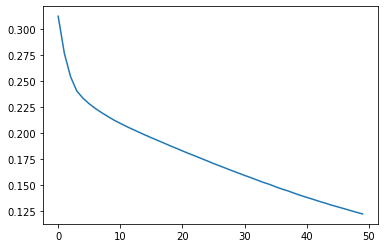

In [138]:
pl.plot(history.history['loss'])

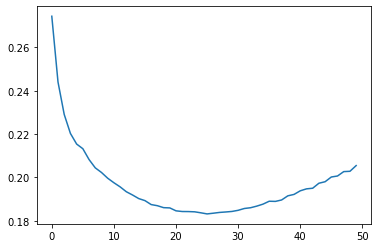

In [139]:
pl.plot(history.history['val_loss'])

In [140]:
encoder_model=Model(encoder_inputs,encoder_states)
decoder_state_input_h=Input(shape=(latent_dim,))
decoder_state_input_c=Input(shape=(latent_dim,))
decoder_states_inputs=[decoder_state_input_h,decoder_state_input_c]

decoder_outputs,state_h,state_c=decoder_lstm(decoder_inputs,
                                    initial_state=decoder_states_inputs)

decoder_states=[state_h,state_c]
decoder_outputs=decoder_dense(decoder_outputs)

decoder_model = Model(
  [decoder_inputs] + decoder_states_inputs,
  [decoder_outputs] + decoder_states)

In [146]:
reverse_input_char_index = dict(
  (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
  (i, char) for char, i in target_token_index.items())

In [155]:
def decode_sequences(input_seq):
#     encode the input sequence to get the internal state vectors.
    states_value=encoder_model.predict(input_seq)
    
#     generate empty target sequence of length 1 with only the start
# character
    target_seq=np.zeros((1,1,num_decoder_tokens))
    target_seq[0,0,target_token_index['\t']]=1.
    
# output sequence loop
    stop_condition=False
    decoded_sequence=''
    while not stop_condition:
        output_tokens,h,c=decoder_model.predict([target_seq]+states_value)
        
        sampled_token_index=np.argmax(output_tokens[0,-1,:])
        sampled_char=reverse_target_char_index[sampled_token_index]
        decoded_sequence+=sampled_char
        
        if(sampled_char=='\n' or 
          len(decode_sequence)>max_decoder_len):
            stop_condition=True
        target_seq=np.zeros((1,1,num_encoder_tokens))
        target_seq[0,0,sampled_token_index]=1.
        states_value=[h,c]
    return decode_sequence


decode_sequences(encoder_input_data[0])

ValueError: Error when checking input: expected input_25 to have 3 dimensions, but got array with shape (100, 113)

In [154]:
encoder_input_data[1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)